In [1]:
import sys
sys.path.insert(0, '../src')
import harmoutil

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

import matplotlib.pyplot as plt

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
print("---Raw data---")
print("Number of sections: {}".format(len(raw_data)))
print("Sample section: {}\n".format(raw_data[0]))
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
print("---Transpose and augment data---")
print("Number of sections after data augmentation: {}".format(len(augmented_data)))
print("Sample section: {}\n".format(augmented_data[0]))
data = [harmoutil.to_sevenths(section) for section in augmented_data]
print("---Truncate chords to sevenths---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))
data = [harmoutil.melody_to_octave_range(section) for section in data]
print("---Convert melody to integers---")
print("Number of sections: {}".format(len(data)))
print("Sample section: {}\n".format(data[0]))

---Raw data---
Number of sections: 2408
Sample section: [('Bb6', [[58.0], [58.0]]), ('G7', [[-1.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]]), ('Bb', [[-1.0], [-1.0]]), ('G-7', [[50.0], [57.0, 60.0]]), ('C-7', [[58.0, 55.0], [58.0]]), ('F7', [[61.0], [60.0, 58.0]]), ('F-7', [[60.0], [58.0]]), ('Bb7', [[56.0, 60.0], [59.0, 57.0]]), ('Eb7', [[58.0, 54.0], [55.0, 58.0]]), ('Ab7', [[61.0, 56.0], [61.0, 62.0]]), ('D-7', [[58.0, 60.0], [55.0, 58.0]]), ('G7', [[58.0], [-1.0]]), ('C-7', [[-1.0], [-1.0]]), ('F7', [[-1.0], [-1.0]])]

---Transpose and augment data---
Number of sections after data augmentation: 28884
Sample section: [('E6', [[52.0], [52.0]]), ('Db7', [[-1.0], [-1.0]]), ('Gb-7', [[-1.0], [-1.0]]), ('B7', [[-1.0], [-1.0]]), ('E', [[-1.0], [-1.0]]), ('Db-7', [[44.0], [51.0, 54.0]]), ('Gb-7', [[52.0, 49.0], [52.0]]), ('B7', [[55.0], [54.0, 52.0]]), ('B-7', [[54.0], [52.0]]), ('E7', [[50.0, 54.0], [53.0, 51.0]]), ('A7', [[52.0, 48.0], [49.0, 52.0]]), ('D7', [[55.0, 

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def get_melodies_by_section(section):
    return [chord_info[1] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

melodies_by_sections = [get_melodies_by_section(section) for section in data]
chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

---Remove sections with augmented major chord---
Number of sections: 28836

Number of sections: 28836 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 333480 | Sample chord: E6
Number of melodies 333480 | Sample melody: [4, 4]
Number of melody notes in the data: 2195328 | Sample melody note: 4


In [4]:
# Create categorical data mappings

# Note to integer index
note_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)
print("Melody note to integer mapping:\n {}\n".format(note_to_int))

# Integer to note
int_to_note = dict([(k, v) for v, k in note_to_int.items()])
print("Integer to melody note mapping:\n {}\n".format(int_to_note))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))


# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'B-7': 35, 'Db-j7': 90, 'Cm7b5': 70, 'Bb+': 40, 'F6': 142, 'B-6': 34, 'G-': 153, 'Go': 176, 'A-': 3, 'F7': 143, 'A': 0, 'Ao7': 27, 'Db6': 91, 'G+': 151, 'Bsus': 58, 'Gbsus7': 173, 'Bbo': 50, 'Dbj7': 93, 'Eb7': 122, 'Csus7': 74, 'Gj7': 174, 'Ab7': 17, 'Gbj7': 168, 'C+7': 62, 'Fm7b5': 145, 'Bbsus7': 53, 'A-7': 5, 'Bbo7': 51, 'Co': 71, '<bos>': 181, 'Dbsus7': 98, 'Eb': 114, 'Dm7b5': 100, 'G-7': 155, 'Am7b5': 25, 'Asus': 28, 'Aj7': 24, 'F+7': 137, 'F': 135, 'Bb+7': 41, 'C-6': 64, 'G-j7': 156, 'D7': 83, 'E-6': 109, 'A-6': 4, 'Ab6': 16, 'Gsus7': 179, 'Gb-j7': 165, 'Do': 101, 'Abm7b5': 19, 'C-7': 65, 'E7': 113, 'Db+': 85, 'G7': 158, 'F-6': 139, 'F+': 136, 'Csus': 73, 'Co7': 72, 'Ebo': 125, 'Ebsus': 1

In [5]:
# Define numerical variables

n_samples = len(chords)
n_notes = len(note_to_int)
n_chords = len(chord_to_int)
max_melody_len = max([len(mel_seq) for mel_seq in notes_by_chords])
chord_context_len = 7
past_melody_len = 1

print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum melody sequence length: {}".format(max_melody_len))
print("Fixed context chord sequence length: {}".format(chord_context_len))
print("Number of past melody sequences corresponding to chords: {}".format(past_melody_len))

Total number of samples: 333480
Number of distinct melody notes: 14
Number of distinct chord labels: 182
Maximum melody sequence length: 135
Fixed context chord sequence length: 7
Number of past melody sequences corresponding to chords: 1


In [6]:
def past_melody_by_offset(section, offset):
    section_melody = [chord_info[1] for chord_info in section]

    for i in range(offset):
        section_melody.insert(0, [[-1]])
    
    past_melody = []
    for i, chord_info in enumerate(section):
        past_melody.append(section_melody[0+i:offset+i])

    return past_melody

def get_note_sequence_by_chord(chords_melodies):
    chord_melody = []
    for chord_mel in chords_melodies:
        for beat in chord_mel:
            chord_melody += beat
    return chord_melody

past_notes_by_sections = [past_melody_by_offset(section, past_melody_len) for section in data]
# below works only for past_melody_len = 1 i think
past_notes_by_chords = [get_note_sequence_by_chord(chords_melo) for section in past_notes_by_sections for chords_melo in section] 

In [7]:
# Prepare tensor data

def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences
    

    
# Melody
input_melody_data = [pad_melody(melody, max_melody_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[2]))
input_past_melody_data = [pad_melody(melody, max_melody_len) for melody in past_notes_by_chords]

# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

Sample input melody sequence: [-1, -1, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

In [8]:
# Build tensors

X_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_past_melody = np.zeros((n_samples, max_melody_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_past_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_past_melody_data, input_chords_data, target_chords_data)):
    Y[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
        X_chords[i, j, chord_to_int[chord]] = 1
        
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1
        
    for j, past_note in enumerate(input_past_mel):
        X_melody[i, j, note_to_int[note]] = 1
        

In [9]:
# Test melody tensor

def test_samples_axis(melody_tensor):
    count = 0
    sample_axis_sums = melody_tensor.sum(axis=2)
    for entry in sample_axis_sums.ravel():
        count += 1
        if not (entry == 1):
            return (False, count)
    return (True, count, np.sum(sample_axis_sums), np.sum(melody_tensor), np.sum(melody_tensor, dtype=np.int32))

# Test n_samples axis i.e. axis 1. If there are any "holes" (non-1) entry, it's a problem
print("{} = (n_samples, max_melody_len, n_notes)".format(X_melody.shape))
print(test_samples_axis(X_melody))

(333480, 135, 14) = (n_samples, max_melody_len, n_notes)
(False, 1)


In [10]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_past_melody_train, X_past_melody_aux = X_past_melody[train_index], X_past_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_train, Y_aux = Y[train_index], Y[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_past_melody_valid, X_past_melody_test = X_past_melody[valid_index], X_past_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_valid, Y_test = Y[valid_index], Y[test_index]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 7, 182)        0                                            
____________________________________________________________________________________________________
gru_4 (GRU)                      (None, 135, 128)      54912       input_2[0][0]                    
____________________________________________________________________________________________________
gru_8 (GRU)                      (None, 7, 128)        119424      input_4[0][0]                    
__________________

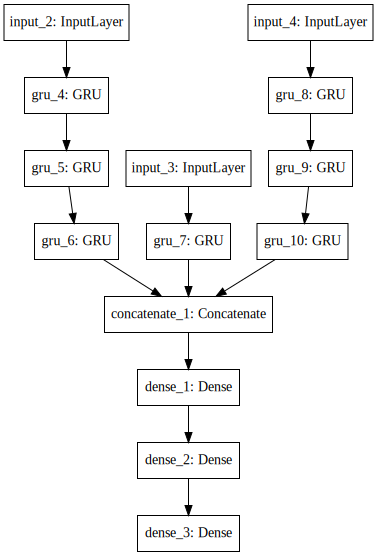

In [12]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_melody_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim, return_sequences=True)(melody_gru1)
melody_gru3 = GRU(latent_dim)(melody_gru2)

pastmelo_input = Input(shape=(max_melody_len, n_notes))
pastmelo_gru = GRU(latent_dim)(pastmelo_input)

chords_input = Input(shape=(chord_context_len, n_chords))
chords_gru1 = GRU(latent_dim, return_sequences=True)(chords_input)
chords_gru2 = GRU(latent_dim, return_sequences=True)(chords_gru1)
chords_gru3 = GRU(latent_dim)(chords_gru2)

concat = concatenate([melody_gru3, pastmelo_gru, chords_gru3])

chord_hidden1 = Dense(latent_dim, activation='relu')(concat)
chord_hidden2 = Dense(latent_dim, activation='relu')(chord_hidden1)
chord_dense = Dense(n_chords, activation='softmax')(chord_hidden2)

model = Model([melody_input, pastmelo_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [13]:
# Introduce Early-Stopping and Save-Best-Performance callbacks
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../models/label-Mel3-Cho3-FC3_pastmelody1.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [14]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_past_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_past_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[bp])

Train on 266784 samples, validate on 33348 samples
Epoch 1/150
266784/266784 [==============================] - 1594s - loss: 3.0698 - acc: 0.3018 - val_loss: 2.5586 - val_acc: 0.4112
Epoch 2/150
266784/266784 [==============================] - 1594s - loss: 2.3512 - acc: 0.4428 - val_loss: 2.2995 - val_acc: 0.4641
Epoch 3/150
266784/266784 [==============================] - 1595s - loss: 2.1059 - acc: 0.4955 - val_loss: 2.1412 - val_acc: 0.4994
Epoch 4/150
266784/266784 [==============================] - 1595s - loss: 1.9271 - acc: 0.5354 - val_loss: 2.0173 - val_acc: 0.5302
Epoch 5/150
266784/266784 [==============================] - 1595s - loss: 1.7842 - acc: 0.5702 - val_loss: 1.9252 - val_acc: 0.5544
Epoch 6/150
266784/266784 [==============================] - 1592s - loss: 1.6665 - acc: 0.5971 - val_loss: 1.8457 - val_acc: 0.5743
Epoch 7/150
266784/266784 [==============================] - 1590s - loss: 1.5676 - acc: 0.6194 - val_loss: 1.7823 - val_acc: 0.5853
Epoch 8/150
266784

266784/266784 [==============================] - 1594s - loss: 1.0243 - acc: 0.7328 - val_loss: 1.4636 - val_acc: 0.6728
Epoch 27/150
266784/266784 [==============================] - 1594s - loss: 1.0164 - acc: 0.7349 - val_loss: 1.4642 - val_acc: 0.6752
Epoch 28/150
266784/266784 [==============================] - 1598s - loss: 1.0100 - acc: 0.7349 - val_loss: 1.4537 - val_acc: 0.6754
Epoch 29/150
266784/266784 [==============================] - 1596s - loss: 1.0011 - acc: 0.7373 - val_loss: 1.4406 - val_acc: 0.6796
Epoch 30/150
266784/266784 [==============================] - 1592s - loss: 0.9883 - acc: 0.7386 - val_loss: 1.4307 - val_acc: 0.6799
Epoch 31/150
266784/266784 [==============================] - 1595s - loss: 0.9699 - acc: 0.7417 - val_loss: 1.4094 - val_acc: 0.6877
Epoch 32/150
266784/266784 [==============================] - 1600s - loss: 0.9561 - acc: 0.7444 - val_loss: 1.3927 - val_acc: 0.6872
Epoch 33/150
266784/266784 [==============================] - 1598s - loss:

266784/266784 [==============================] - 1589s - loss: 0.8393 - acc: 0.7682 - val_loss: 1.3499 - val_acc: 0.7060
Epoch 55/150
266784/266784 [==============================] - 1587s - loss: 0.8372 - acc: 0.7680 - val_loss: 1.3297 - val_acc: 0.7086
Epoch 56/150
266784/266784 [==============================] - 1592s - loss: 0.8805 - acc: 0.7592 - val_loss: 1.4245 - val_acc: 0.6861
Epoch 57/150
266784/266784 [==============================] - 1594s - loss: 0.8968 - acc: 0.7539 - val_loss: 1.3743 - val_acc: 0.6976
Epoch 58/150
266784/266784 [==============================] - 1593s - loss: 0.8589 - acc: 0.7627 - val_loss: 1.3649 - val_acc: 0.7044
Epoch 59/150
266784/266784 [==============================] - 1592s - loss: 0.8399 - acc: 0.7673 - val_loss: 1.3444 - val_acc: 0.7084
Epoch 60/150
266784/266784 [==============================] - 1591s - loss: 0.8317 - acc: 0.7691 - val_loss: 1.3394 - val_acc: 0.7061
Epoch 61/150
266784/266784 [==============================] - 1592s - loss:

266784/266784 [==============================] - 1596s - loss: 0.7080 - acc: 0.8002 - val_loss: 1.3203 - val_acc: 0.7291
Epoch 83/150
266784/266784 [==============================] - 1595s - loss: 0.6599 - acc: 0.8130 - val_loss: 1.3139 - val_acc: 0.7324
Epoch 84/150
266784/266784 [==============================] - 1595s - loss: 0.6375 - acc: 0.8189 - val_loss: 1.3102 - val_acc: 0.7367
Epoch 85/150
266784/266784 [==============================] - 1595s - loss: 0.6255 - acc: 0.8227 - val_loss: 1.3046 - val_acc: 0.7395
Epoch 86/150
266784/266784 [==============================] - 1594s - loss: 0.6419 - acc: 0.8173 - val_loss: 1.3175 - val_acc: 0.7372
Epoch 87/150
266784/266784 [==============================] - 1594s - loss: 0.6061 - acc: 0.8272 - val_loss: 1.3232 - val_acc: 0.7392
Epoch 88/150
266784/266784 [==============================] - 1593s - loss: 0.6085 - acc: 0.8267 - val_loss: 1.3238 - val_acc: 0.7400
Epoch 89/150
266784/266784 [==============================] - 1593s - loss:

266784/266784 [==============================] - 1589s - loss: 0.4173 - acc: 0.8790 - val_loss: 1.4255 - val_acc: 0.7576
Epoch 111/150
266784/266784 [==============================] - 1593s - loss: 0.4271 - acc: 0.8764 - val_loss: 1.4414 - val_acc: 0.7544
Epoch 112/150
266784/266784 [==============================] - 1592s - loss: 0.4090 - acc: 0.8820 - val_loss: 1.4140 - val_acc: 0.7636
Epoch 113/150
266784/266784 [==============================] - 1594s - loss: 0.4086 - acc: 0.8823 - val_loss: 1.4718 - val_acc: 0.7557
Epoch 114/150
266784/266784 [==============================] - 1595s - loss: 0.4039 - acc: 0.8839 - val_loss: 1.4468 - val_acc: 0.7622
Epoch 115/150
266784/266784 [==============================] - 1596s - loss: 0.3975 - acc: 0.8855 - val_loss: 1.4352 - val_acc: 0.7617
Epoch 116/150
266784/266784 [==============================] - 1595s - loss: 0.3954 - acc: 0.8860 - val_loss: 1.4517 - val_acc: 0.7597
Epoch 117/150
266784/266784 [==============================] - 1595s 

266784/266784 [==============================] - 1595s - loss: 0.3295 - acc: 0.9049 - val_loss: 1.5381 - val_acc: 0.7641
Epoch 141/150
266784/266784 [==============================] - 1594s - loss: 0.3304 - acc: 0.9038 - val_loss: 1.5390 - val_acc: 0.7666
Epoch 142/150
266784/266784 [==============================] - 1594s - loss: 0.3384 - acc: 0.9023 - val_loss: 1.5338 - val_acc: 0.7634
Epoch 143/150
266784/266784 [==============================] - 1594s - loss: 0.3449 - acc: 0.8999 - val_loss: 1.5298 - val_acc: 0.7705
Epoch 144/150
266784/266784 [==============================] - 1593s - loss: 0.3166 - acc: 0.9083 - val_loss: 1.5425 - val_acc: 0.7671
Epoch 145/150
266784/266784 [==============================] - 1594s - loss: 0.3413 - acc: 0.9008 - val_loss: 1.5341 - val_acc: 0.7682
Epoch 146/150
266784/266784 [==============================] - 1595s - loss: 0.3251 - acc: 0.9059 - val_loss: 1.5682 - val_acc: 0.7675
Epoch 147/150
266784/266784 [==============================] - 1596s 

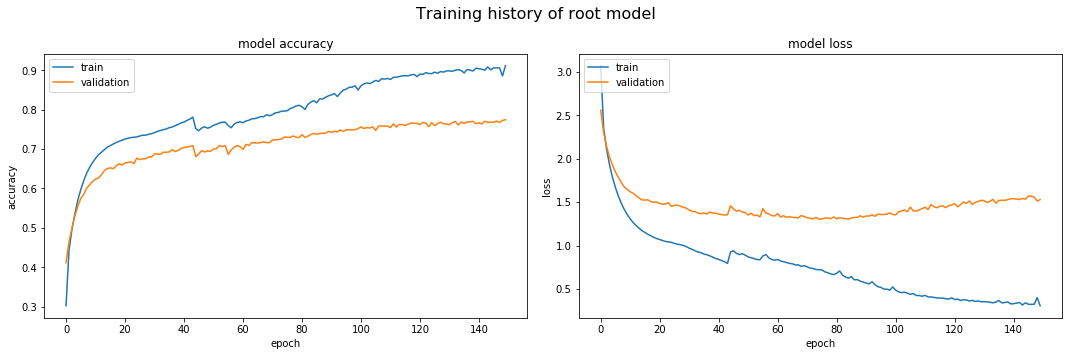

In [15]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [16]:
# Load best performance model
model = load_model("../models/label-Mel3-Cho3-FC3_pastmelody1.h5")

In [18]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_pred = model.predict([X_melody_test, X_past_melody_test, X_chords_test])

# Compute accuracy and kappa score
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_test, Y_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_test, Y_pred)))

Categorical accuracy of combined chord label prediction: 0.7745
Kappa score of combined chord label prediction: 0.7690


In [19]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_pred_pitch = label_to_pitch_tensors(Y_pred)
Y_test_pitch = label_to_pitch_tensors(Y_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_test_pitch, Y_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_test_pitch, Y_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9087
TP: 111889 TN: 251743 FP: 18307 FN: 18237
Kappa score of combined chord pitch prediction: 0.7919


In [61]:
# print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(Y_test_pitch, Y_pred_pitch)))